In [23]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

In [24]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [25]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=4)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [26]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [32]:
Params={'L': 26, 'P': 0.38933571213171664, 'Inh': 0.004472182482755209, 'Trest': -9.70287420765931, 'Trelative': -1.4528164770127932, 'C_h': 0.6985403856770942, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


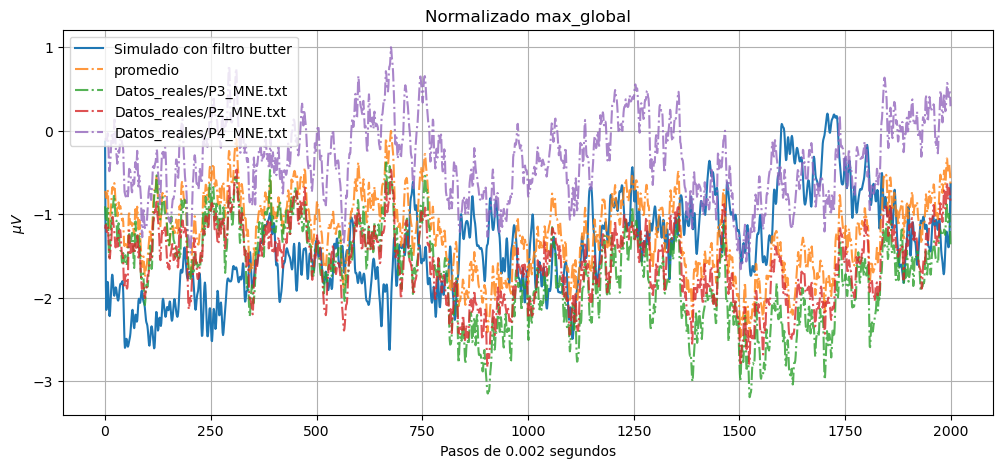

In [33]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 
ax.plot(promedio,"-.", label="promedio",alpha=0.8)
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75]
481
481
241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [-13.296915860028687, 4.121402686497305] ---- [-16.27673048   2.88731357]
Theta [-21.491718237506774, 2.4370244104684673] ---- [-20.92068321   1.24868298]
Alpha [-25.92863027383232, 1.8174448067714293] ---- [-23.45965005   1.65514777]
Beta [-30.534145370425957, 2.2522078377493053] ---- [-30.85932355   2.14585146]


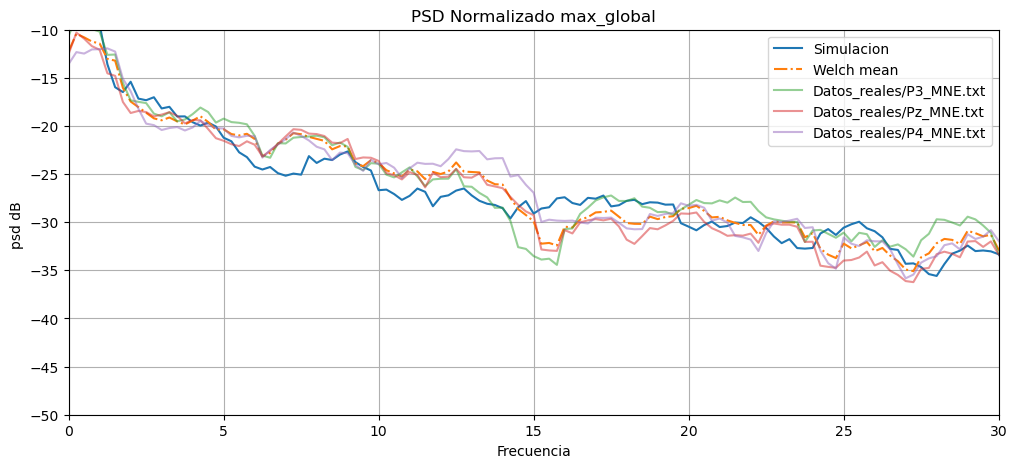

In [34]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-50,-10)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [40]:

def objective(trial):
    params = np.zeros(8)
    params[0] = 21 #trial.suggest_int('L',10,150)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] =  2 #trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
         ### ------------------ Por bandas
        # dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        # dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        # dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        # dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        # difference = (np.sum(np.abs(dif_Delta)) +
        #                     np.sum(np.abs(dif_Theta)) +
        #                     np.sum(np.abs(dif_Alpha)) +
        #                     np.sum(np.abs(dif_Beta)))
        
        ### -------------------- Chi
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L21", 
                            storage=f"sqlite:///Estudios/Chi30_{Normalizacion}_L21.db", 
                            load_if_exists=True,pruner=MedianPruner())

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-11-04 19:22:44,912] Using an existing study with name 'Chi30_max_global_L21' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:45,779] Trial 1138 finished with value: 27303.712815165563 and parameters: {'P': 0.348141073493903, 'Inh': 0.2572966470090033, 'Trest': -3.6222702887326705, 'Trelative': 4.71541571998931, 'C_h': 0.07691234085698412}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:46,439] Trial 1139 finished with value: 70664.76460249683 and parameters: {'P': 0.34401997963285014, 'Inh': 0.2760895072001312, 'Trest': 7.777465058028817, 'Trelative': 12.661310811348239, 'C_h': 0.04995214555365307}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:46,807] Trial 1140 finished with value: 10770.951261033137 and parameters: {'P': 0.37552398629682904, 'Inh': 0.25145713852138907, 'Trest': -4.146859121230596, 'Trelative': -1.124085619122598, 'C_h': 0.042409212242343765}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:47,270] Trial 1141 finished with value: 2250.4224082417327 and parameters: {'P': 0.4795507812879343, 'Inh': 0.2852157628628044, 'Trest': -4.6592872297360595, 'Trelative': -0.9688312614505779, 'C_h': 0.06866455993142874}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:47,644] Trial 1142 finished with value: 20086.130087485213 and parameters: {'P': 0.3279817265308462, 'Inh': 0.24922461394990716, 'Trest': -4.3866907422273425, 'Trelative': -1.3059870266529257, 'C_h': 0.08405802872436254}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:48,000] Trial 1143 finished with value: 19710.39030745112 and parameters: {'P': 0.32730656983474493, 'Inh': 0.8334311737072342, 'Trest': -3.6944979180639423, 'Trelative': -1.4644842076955276, 'C_h': 0.03802483046078414}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:48,427] Trial 1144 finished with value: 931.9648820916883 and parameters: {'P': 0.3801059986543525, 'Inh': 0.3106941238370228, 'Trest': -4.954418470148707, 'Trelative': -0.8332376905937031, 'C_h': 0.05100278034777207}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:48,835] Trial 1145 finished with value: 3443.007668658458 and parameters: {'P': 0.3832737913388886, 'Inh': 0.06698351454640705, 'Trest': -4.8880562275374935, 'Trelative': -1.1151781092367838, 'C_h': 0.08821338095771754}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:49,256] Trial 1146 finished with value: 1969.1117746376622 and parameters: {'P': 0.35708956996513225, 'Inh': 0.2394158201234856, 'Trest': -4.5672601433554, 'Trelative': -0.9714747850064771, 'C_h': 0.06249292548543853}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:49,695] Trial 1147 finished with value: 1335.9642823983502 and parameters: {'P': 0.30870660255956983, 'Inh': 0.26707596606206696, 'Trest': -3.812034394945543, 'Trelative': -0.8404734595550902, 'C_h': 0.807265249778464}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:50,106] Trial 1148 finished with value: 2380.5284331035573 and parameters: {'P': 0.3435005541124253, 'Inh': 0.24865438855737912, 'Trest': -5.116735284942235, 'Trelative': -0.7332725918581346, 'C_h': 0.035517632136153575}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:50,472] Trial 1149 finished with value: 20848.372515291798 and parameters: {'P': 0.3921267203786073, 'Inh': 0.23063046526387593, 'Trest': -4.214950364160854, 'Trelative': -1.1546239433769285, 'C_h': 0.06955449917495443}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:51,142] Trial 1150 finished with value: 70664.76460249683 and parameters: {'P': 0.30932970858332065, 'Inh': 0.2885618828593528, 'Trest': 9.383835249528452, 'Trelative': 9.409403611955598, 'C_h': 0.09497424631137454}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:51,602] Trial 1151 finished with value: 5183.749698588248 and parameters: {'P': 0.3344309461371074, 'Inh': 0.3271970875672726, 'Trest': -4.73303917212495, 'Trelative': -0.8162252267152497, 'C_h': 0.03488723734290948}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:52,048] Trial 1152 finished with value: 1956.5568587492044 and parameters: {'P': 0.30406837856630153, 'Inh': 0.2647603674466225, 'Trest': -5.883396362956279, 'Trelative': -0.6571673185598511, 'C_h': 0.05679808528225349}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:52,456] Trial 1153 finished with value: 2576.1551324738157 and parameters: {'P': 0.31891896498434913, 'Inh': 0.234725601317058, 'Trest': -5.295054878072934, 'Trelative': -0.925061424147601, 'C_h': 0.07810938150575902}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:52,841] Trial 1154 finished with value: 18395.678089687768 and parameters: {'P': 0.293803061670092, 'Inh': 0.2955080539813809, 'Trest': -5.599910964618815, 'Trelative': -1.252972297563986, 'C_h': 0.03868861984390286}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:53,230] Trial 1155 finished with value: 13572.12945392922 and parameters: {'P': 0.3332702594504412, 'Inh': 0.3638251461149815, 'Trest': -6.193361603527341, 'Trelative': -1.0317143829209994, 'C_h': 0.10161558325639564}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:53,694] Trial 1156 finished with value: 2804.7515373558444 and parameters: {'P': 0.2925100664194788, 'Inh': 0.256487913950041, 'Trest': -4.886215362166454, 'Trelative': -0.5447592030608226, 'C_h': 0.6329425311133177}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:54,050] Trial 1157 finished with value: 18622.39612424999 and parameters: {'P': 0.3156457142768001, 'Inh': 0.22997728634925743, 'Trest': -4.117513956277042, 'Trelative': -1.7879051892260618, 'C_h': 0.7695295781019565}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:54,447] Trial 1158 finished with value: 1534.5724230392973 and parameters: {'P': 0.40244559183976925, 'Inh': 0.277382445766661, 'Trest': -5.179020394239194, 'Trelative': -0.7259187471525562, 'C_h': 0.058132886907804736}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:54,868] Trial 1159 finished with value: 1859.1314442277437 and parameters: {'P': 0.35838176411908484, 'Inh': 0.2178145593172858, 'Trest': -5.8161098625508405, 'Trelative': -0.5068362003001161, 'C_h': 0.08219016987363582}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:55,353] Trial 1160 finished with value: 516.8839948845197 and parameters: {'P': 0.28115547296434024, 'Inh': 0.25579219446805457, 'Trest': -4.537442584143987, 'Trelative': -1.030313839703616, 'C_h': 0.03974983324795843}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:55,904] Trial 1161 finished with value: 30148.080390662322 and parameters: {'P': 0.276019769928581, 'Inh': 0.29527980964813727, 'Trest': -3.7947932090472567, 'Trelative': 1.078911871473095, 'C_h': 0.027625262341276872}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:56,287] Trial 1162 finished with value: 17265.301206038654 and parameters: {'P': 0.23965637724196828, 'Inh': 0.2746706412124254, 'Trest': -4.341035057305726, 'Trelative': -1.3526701711604718, 'C_h': 0.024036710137133037}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:56,655] Trial 1163 finished with value: 15680.243612328646 and parameters: {'P': 0.2761671354133774, 'Inh': 0.2594959452274744, 'Trest': -4.058444242108944, 'Trelative': -1.3866717086769604, 'C_h': 0.03158667564684885}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:22:57,027] Trial 1164 finished with value: 20101.861832609 and parameters: {'P': 0.25186131298899767, 'Inh': 0.3235488930950292, 'Trest': -6.187613134371047, 'Trelative': -1.157746458413762, 'C_h': 0.04467024355117292}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:57,383] Trial 1165 finished with value: 21450.172416175425 and parameters: {'P': 0.21993554649698613, 'Inh': 0.30409617991232135, 'Trest': -4.411308736020312, 'Trelative': -1.0460381241924377, 'C_h': 0.01974841216114653}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:57,787] Trial 1166 finished with value: 18842.08957519752 and parameters: {'P': 0.27965144067681896, 'Inh': 0.27032494412181957, 'Trest': -5.486187522240259, 'Trelative': -1.2115935069256563, 'C_h': 0.045121320159475925}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:58,320] Trial 1167 finished with value: 30032.90785272705 and parameters: {'P': 0.2643806862669162, 'Inh': 0.2512058375508107, 'Trest': -3.767828093992989, 'Trelative': 1.577987762300724, 'C_h': 0.018292060582167514}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:58,725] Trial 1168 finished with value: 20135.708348441236 and parameters: {'P': 0.29641692557684596, 'Inh': 0.25175350467477103, 'Trest': -4.649840767594791, 'Trelative': -1.4874481713728849, 'C_h': 0.03237670050072643}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:59,123] Trial 1169 finished with value: 8992.781347615375 and parameters: {'P': 0.2478865493070777, 'Inh': 0.43518618173551815, 'Trest': -5.0568021990169925, 'Trelative': -0.953196299479106, 'C_h': 0.05654898135343404}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:22:59,685] Trial 1170 finished with value: 12766.879783233393 and parameters: {'P': 0.2920606407459048, 'Inh': 0.34300212756168635, 'Trest': 0.2848594820881618, 'Trelative': 0.44826780050344495, 'C_h': 0.0484504139439325}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:00,091] Trial 1171 finished with value: 1614.932251864719 and parameters: {'P': 0.2683941644550459, 'Inh': 0.2831529986699497, 'Trest': -9.996011026551956, 'Trelative': -0.3341422941253569, 'C_h': 0.016728254842105352}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:00,559] Trial 1172 finished with value: 1823.903528586907 and parameters: {'P': 0.23034766786778066, 'Inh': 0.2694263246342552, 'Trest': -6.458822646624002, 'Trelative': -0.07329657491051655, 'C_h': 0.03729234007743998}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:23:00,933] Trial 1173 finished with value: 16068.410585016587 and parameters: {'P': 0.3104640892792065, 'Inh': 0.24431111398673688, 'Trest': -5.885505676027384, 'Trelative': -1.633646259919817, 'C_h': 0.0593537881271345}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:01,334] Trial 1174 finished with value: 3036.8341395416314 and parameters: {'P': 0.2784683239857852, 'Inh': 0.29182220910100776, 'Trest': -5.470389091203905, 'Trelative': -0.7972809770886278, 'C_h': 0.017295028908043797}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:01,721] Trial 1175 finished with value: 1251.6349835345525 and parameters: {'P': 0.2523394655080201, 'Inh': 0.24211048305005123, 'Trest': -5.110628337329643, 'Trelative': -1.0617173334781136, 'C_h': 0.06570990198733936}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:02,158] Trial 1176 finished with value: 2512.3340240128223 and parameters: {'P': 0.3011143100797086, 'Inh': 0.2619642594746069, 'Trest': -6.83411944626543, 'Trelative': -0.1808699079382442, 'C_h': 0.04171222535829819}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:02,553] Trial 1177 finished with value: 20948.46479399536 and parameters: {'P': 0.32296681159645846, 'Inh': 0.30723641525066825, 'Trest': -3.553700933510674, 'Trelative': -1.2838080136976928, 'C_h': 0.031344285970975064}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:23:02,919] Trial 1178 finished with value: 9525.252068933532 and parameters: {'P': 0.2828375080095024, 'Inh': 0.5687987169096796, 'Trest': -4.671560365872403, 'Trelative': -0.8983930253274132, 'C_h': 0.07024685073046555}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:03,330] Trial 1179 finished with value: 1347.220760721894 and parameters: {'P': 0.20795451322637712, 'Inh': 0.27715994144738787, 'Trest': -6.025679208487569, 'Trelative': -0.614859305217767, 'C_h': 0.014285480469571156}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:03,753] Trial 1180 finished with value: 734.9936764716074 and parameters: {'P': 0.25925374692293185, 'Inh': 0.237221929624311, 'Trest': -5.584764549969145, 'Trelative': -0.7381439931742211, 'C_h': 0.05443438091485375}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:04,114] Trial 1181 finished with value: 19575.46963417675 and parameters: {'P': 0.29521953864798384, 'Inh': 0.2515349410673605, 'Trest': -4.371141889633319, 'Trelative': -1.1215122138587816, 'C_h': 0.03498160246795148}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:04,568] Trial 1182 finished with value: 2130.2924137169066 and parameters: {'P': 0.23241656530424493, 'Inh': 0.234171278586413, 'Trest': -6.32880072383357, 'Trelative': -0.43246814740200956, 'C_h': 0.06653297300682753}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:04,991] Trial 1183 finished with value: 1826.2397994982248 and parameters: {'P': 0.33206617599475036, 'Inh': 0.2797991109625598, 'Trest': -5.210525188139193, 'Trelative': -0.6598737373293906, 'C_h': 0.013986274847163693}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:23:05,670] Trial 1184 finished with value: 70664.76460249683 and parameters: {'P': 0.27391356884191537, 'Inh': 0.2609543014772927, 'Trest': 4.234574510963532, 'Trelative': 4.282285567620396, 'C_h': 0.09610098239679592}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:06,085] Trial 1185 finished with value: 1915.3765795100446 and parameters: {'P': 0.3120746610017855, 'Inh': 0.22492211269489776, 'Trest': -5.7908454021432725, 'Trelative': -0.9422061872605648, 'C_h': 0.04837429520082942}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:06,602] Trial 1186 finished with value: 4346.8083971173255 and parameters: {'P': 0.2543181373963596, 'Inh': 0.2933733635378734, 'Trest': -4.821759837210883, 'Trelative': 0.07219088191347739, 'C_h': 0.07809756069350841}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:23:07,004] Trial 1187 finished with value: 20981.947916118963 and parameters: {'P': 0.29228159098160006, 'Inh': 0.31933935881706704, 'Trest': -4.049339544893069, 'Trelative': -1.462265930791892, 'C_h': 0.03170305036855089}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:07,446] Trial 1188 finished with value: 2494.538182251003 and parameters: {'P': 0.27089108553628866, 'Inh': 0.24735090681848865, 'Trest': -5.381827155250477, 'Trelative': -0.4874631413295542, 'C_h': 0.0011054802873887888}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-04 19:23:07,916] Trial 1189 finished with value: 27876.589059604703 and parameters: {'P': 0.34339919858446344, 'Inh': 0.22038525827230965, 'Trest': -0.5001458903533468, 'Trelative': -0.26428891695632695, 'C_h': 0.04752620240468584}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:08,458] Trial 1190 finished with value: 1925.6097877744837 and parameters: {'P': 0.4353922290924792, 'Inh': 0.27029910816291125, 'Trest': -5.989613400750568, 'Trelative': -0.7941038603225588, 'C_h': 0.7056990935792748}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:08,831] Trial 1191 finished with value: 4193.414953684843 and parameters: {'P': 0.238437959816126, 'Inh': 0.23747999092808839, 'Trest': -4.978978009299233, 'Trelative': -1.0469281738587337, 'C_h': 0.10881740162092024}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:09,253] Trial 1192 finished with value: 1416.7287335851563 and parameters: {'P': 0.3145928913509368, 'Inh': 0.21724558726035192, 'Trest': -6.4501477226257204, 'Trelative': -0.5919254611516782, 'C_h': 0.06594222048160292}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:09,691] Trial 1193 finished with value: 605.3587125200845 and parameters: {'P': 0.2885709431018556, 'Inh': 0.25756878228447505, 'Trest': -5.520511502094691, 'Trelative': -0.8375672769623363, 'C_h': 0.029160224061205896}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:10,111] Trial 1194 finished with value: 2866.478354751739 and parameters: {'P': 0.356990831671218, 'Inh': 0.29078145044144377, 'Trest': -5.671094730452997, 'Trelative': -0.44712802935493245, 'C_h': 0.01919531216195561}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:10,539] Trial 1195 finished with value: 1760.4261780130385 and parameters: {'P': 0.3282104029914834, 'Inh': 0.26844093362032867, 'Trest': -5.471075497309006, 'Trelative': -0.6647749967150278, 'C_h': 0.018189792648715154}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:10,994] Trial 1196 finished with value: 2030.7589647599232 and parameters: {'P': 0.30871851892964813, 'Inh': 0.3113970045768583, 'Trest': -6.093579739872453, 'Trelative': -0.2631908343533457, 'C_h': 0.01562605150014889}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:11,410] Trial 1197 finished with value: 2468.6756309274506 and parameters: {'P': 0.2918383973373676, 'Inh': 0.2840037610954015, 'Trest': -5.612873923469778, 'Trelative': -0.799708396139743, 'C_h': 0.0005660439628274172}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:11,851] Trial 1198 finished with value: 3207.1870603692364 and parameters: {'P': 0.3257542068058568, 'Inh': 0.2547371686753505, 'Trest': -5.158880962561721, 'Trelative': -0.4845436534713488, 'C_h': 0.034830531067422565}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:12,304] Trial 1199 finished with value: 1284.0487027171437 and parameters: {'P': 0.3010724148079582, 'Inh': 0.26863278918843736, 'Trest': -5.978507532146404, 'Trelative': -0.10023231589148979, 'C_h': 0.033830216030307114}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:12,733] Trial 1200 finished with value: 4907.754076866686 and parameters: {'P': 0.2806665649215372, 'Inh': 0.3025495205679116, 'Trest': -6.768687627106708, 'Trelative': -0.24292515736232695, 'C_h': 0.029404874482115255}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:13,214] Trial 1201 finished with value: 1955.6219937369378 and parameters: {'P': 0.33715116066088935, 'Inh': 0.09408839853569022, 'Trest': -5.369124657063526, 'Trelative': -0.6156264893852432, 'C_h': 0.01451961575923462}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:13,661] Trial 1202 finished with value: 225.28031193957548 and parameters: {'P': 0.2562387519946944, 'Inh': 0.26560411348456864, 'Trest': -5.876997002731845, 'Trelative': -0.8561174784194734, 'C_h': 0.046074592065111816}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:14,230] Trial 1203 finished with value: 3201.4496776915985 and parameters: {'P': 0.22334742079909642, 'Inh': 0.3344785151926537, 'Trest': -6.552992641192765, 'Trelative': 0.2755026159049692, 'C_h': 0.031095091576978443}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:14,780] Trial 1204 finished with value: 4343.270730461007 and parameters: {'P': 0.2565807993050641, 'Inh': 0.2877561595400041, 'Trest': -7.347994005419919, 'Trelative': 0.08521104677587577, 'C_h': 0.0016426438472559313}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:15,258] Trial 1205 finished with value: 915.8344377402287 and parameters: {'P': 0.3062739034105656, 'Inh': 0.3073447505605236, 'Trest': -6.303752560025435, 'Trelative': -0.8221435694137904, 'C_h': 0.04584485150309024}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:15,722] Trial 1206 finished with value: 661.8547418566646 and parameters: {'P': 0.2864680270547882, 'Inh': 0.2733644405690058, 'Trest': -5.948523884844691, 'Trelative': -0.44254341591741425, 'C_h': 0.028002355925958622}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:16,132] Trial 1207 finished with value: 1158.9090352485514 and parameters: {'P': 0.5252581794343372, 'Inh': 0.29365311686144324, 'Trest': -5.765546586039337, 'Trelative': -0.7325525828508666, 'C_h': 0.049737709333905165}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:16,546] Trial 1208 finished with value: 1796.9082059045659 and parameters: {'P': 0.1904316894581255, 'Inh': 0.2647612115870281, 'Trest': -6.998662607822698, 'Trelative': -0.2050773953800612, 'C_h': 0.01797384350144909}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:16,948] Trial 1209 finished with value: 889.5581089262585 and parameters: {'P': 0.3722406134868671, 'Inh': 0.28724316066643624, 'Trest': -6.263194597942919, 'Trelative': -0.9485587507949517, 'C_h': 0.0014073490488966806}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[I 2024-11-04 19:23:17,376] Trial 1210 finished with value: 1329.7540463006178 and parameters: {'P': 0.2653968704402013, 'Inh': 0.2567282606872344, 'Trest': -5.635148426407436, 'Trelative': -0.6288863603354862, 'C_h': 0.03998366682574824}. Best is trial 793 with value: 168.57768448887057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[W 2024-11-04 19:23:17,815] Trial 1211 failed with parameters: {'P': 0.31606252493783027, 'Inh': 0.27674915557791013, 'Trest': -6.187531323695073, 'Trelative': -0.4687191387083287, 'C_h': 0.05122198332910191} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4630/600029849.py", line 13, in objective
    generated_data_total = Simulado_EGG(params,Normalizacion)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4630/3730341809.py", line 38, in Simulado_EGG
    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=4)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [38]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi30_max_global_L21

Trial 1:
Params: {'P': 0.2805214124452322, 'Inh': 0.20235529438318364, 'Trest': -6.117416283860919, 'Trelative': -0.9921781622317478, 'C_h': 0.019378476974020783}
Value: 191.25168908669673

Trial 2:
Params: {'P': 0.2857155420272057, 'Inh': 0.22660892271811733, 'Trest': -5.761250048412747, 'Trelative': -0.6460802882635132, 'C_h': 0.053627316719027276}
Value: 252.75876002329883

Trial 3:
Params: {'P': 0.2606319345526617, 'Inh': 0.22466337642478906, 'Trest': -5.0146872437228724, 'Trelative': -0.9697590221068778, 'C_h': 0.05018563337066382}
Value: 415.67568078453354

Trial 4:
Params: {'P': 0.29503884084767634, 'Inh': 0.42985423775600895, 'Trest': -5.818135950939143, 'Trelative': -0.7883908508800004, 'C_h': 0.07713853299926876}
Value: 449.72748736545526

Trial 5:
Params: {'P': 0.30438030200442817, 'Inh': 0.21090760458373756, 'Trest': -5.239518882856653, 'Trelative': -0.589643111273765, 'C_h': 0.021083678148701587}
Value: 516.9730817010588

Trial 6:
Params: {'P': 0.2813

In [ ]:
vis.plot_param_importances(study)

[W 2024-11-04 17:11:44,471] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,472] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,473] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,473] Trial 86 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,474] Trial 97 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,474] Trial 113 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,474] Trial 118 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,474] Trial 127 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,475] Trial 131 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:44,4

In [ ]:
vis.plot_parallel_coordinate(study)

[W 2024-11-04 17:11:48,279] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,280] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,280] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,280] Trial 86 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,281] Trial 97 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,281] Trial 113 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,281] Trial 118 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,282] Trial 127 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,282] Trial 131 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,2

In [ ]:
optuna.visualization.plot_slice(study)

[W 2024-11-04 17:11:48,393] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,393] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 86 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 97 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 113 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 118 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 127 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,396] Trial 131 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,3